# Find the fingerprints of ENSO and the IPO in observed gridded datasets

Purpose
-------

    1.    Decompose the temperature time series into Intrinsic Mode Functions (IMFs) using EMD.
            i)  remove monthly climatology
            ii) remove linear trend over timeseries
    2.    Identify and correlate relevant IMFs with known indices for ENSO and IPO.
    3.    Compute slope of relationship between ENSO/IPO and variable of interest to quantify effect of ENSO/IPO


### IMPORTS

In [11]:

import sys
import os
import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# oceanographic
import gsw as gsw

# statistics
import scipy as sci
from scipy.signal import hilbert
from PyEMD import EMD, CEEMDAN

# regridding package
import xesmf as xe

# Copernicus marine toolbox
#import copernicusmarine
#from pprint import pprint
#copernicusmarine.login()

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sci.__version__)
print("xarray version =", xr.__version__)
print("xesmf version =", xe.__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)


wrkdir="/g/data/es60/pjb581/SPC"
os.chdir(wrkdir)
os.getcwd()


python version = 3.10.
numpy version = 2.1.3
pandas version = 2.2.3
scipy version = 1.15.1
xarray version = 2024.11.0
xesmf version = 0.8.8
cartopy version = 0.24.1
matplotlib version = 3.10.0
cmocean version = v3.0.3


'/g/data/es60/pjb581/SPC'

## Load the SST dataset

In [12]:
%%time

sst = xr.open_dataset("/g/data/es60/pjb581/SPC/data/EN4_sst_2005-2024.nc")['sst']


CPU times: user 13.1 ms, sys: 8.7 ms, total: 21.8 ms
Wall time: 19.7 ms


## Take the monthly anomaly in SSTs

CPU times: user 5.64 s, sys: 322 ms, total: 5.97 s
Wall time: 5.96 s


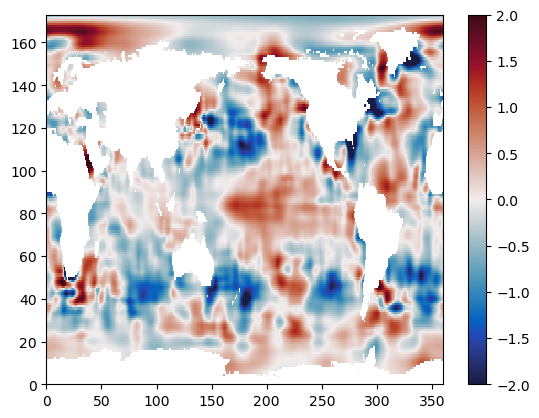

In [13]:
%%time

sst_clim = sst.groupby('time.month').mean('time')
sst_anom = sst.groupby('time.month') - sst_clim

plt.figure()
plt.pcolormesh(sst_anom.isel(time=0), cmap=cmo.balance, vmin=-2, vmax=2)
plt.colorbar()


## detrend the MLD dataset

In [14]:
%%time

### remove global trend
def detrend_1d(arr):
    """Remove the linear trend from a 1D array."""
    x = np.arange(len(arr))
    # Fit a linear trend
    coeffs = np.polyfit(x, arr, 1)
    trend = np.polyval(coeffs, x)
    # Remove the trend
    detrended = arr - trend
    return detrended

sst_detr = xr.apply_ufunc(
    detrend_1d,
    sst_anom,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[sst_anom.dtype]
)



CPU times: user 6.47 s, sys: 673 ms, total: 7.15 s
Wall time: 6.28 s


## determine the linear trends since 2005

CPU times: user 110 ms, sys: 30.3 ms, total: 140 ms
Wall time: 135 ms


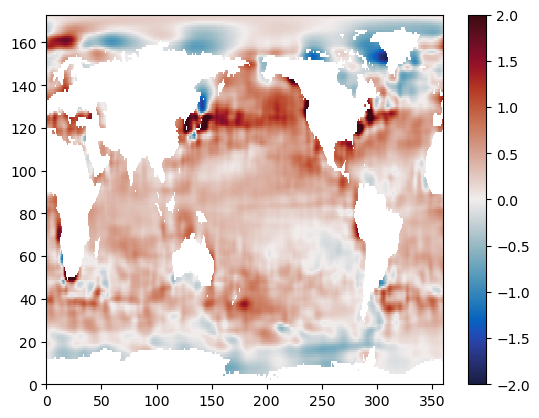

In [15]:
%%time

### retrive the linear least squares trend
sst_trend = sst_anom - sst_detr

### since the trends are linear, they can be described by one number (their slope)
### calculate the slope on a decadal timescale
dates = sst_anom.coords['time']
sst_trend = sst_trend.sel(time=dates[-1]) - sst_trend.sel(time=dates[0]) / len(dates) * 12 * 10

plt.figure()
plt.pcolormesh(sst_trend, cmap=cmo.balance, vmin=-2, vmax=2)
plt.colorbar()


## Undertake the decomposition at each grid cell across the ocean

In [36]:
%%time
from joblib import Parallel, delayed
from scipy.signal import periodogram, hilbert

# Setup CEEMDAN config
def make_ceemdan():
    ceemdan = CEEMDAN()
    ceemdan.noise_seed = 42
    ceemdan.num_siftings = 100
    ceemdan.Nstd = 0.2
    ceemdan.trials = 100
    return ceemdan

# Setup
years = np.arange(2005+0.5/12, 2024+11.51/12, 1/12)
times = sst_anom.coords['time'].values
lats = sst_anom.coords['lat'].values
lons = sst_anom.coords['lon'].values

def find_imf_freq_Hilbert(imfs, years):
    inst_freqs = []
    for imf in imfs:
        analytic_signal = hilbert(imf)
        amplitude_envelope = np.abs(analytic_signal)
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi * np.diff(years))
        inst_freqs.append(instantaneous_frequency)
    return np.array([np.mean(freq) for freq in inst_freqs])


def find_weights_from_freqs(imfs, bands):
    fs = 12  # Hz (cycles per year)
    n_imfs, n_time = imfs.shape
    n_bands = len(bands)
    weights = np.zeros((n_bands, n_imfs))

    # find the frequency power spectra of the different IMFs
    freqs = []
    power = []
    for i in range(n_imfs):
        f, p = periodogram(imfs[i,:], fs=fs, scaling='density', window='hann')
        freqs.append(f)
        power.append(p)
    freqs = np.array(freqs); power = np.array(power)
    
    # find the weights associated with that power spectra
    for i in range(n_imfs):
        total_power = np.sum(power[i,:])
        for j, (f_min, f_max) in enumerate(bands):
            mask = (freqs[i,:] >= f_min) & (freqs[i,:] < f_max)
            band_power = np.sum(power[i][mask])
            weights[j, i] = band_power / total_power if total_power > 0 else 0.0

    return weights
    

def set_bands(imfs, weights):
    return weights @ imfs


# Processing function for each grid cell
def process_cell(ix, iy):
    ceemdan = make_ceemdan()  # Create fresh CEEMDAN instance (safe in parallel)
    signal = sst_detr.isel(lon=ix, lat=iy).values
    if not np.all(np.isfinite(signal)):
        return (ix, iy, None)
    try:
        imfs = ceemdan(signal)
        weights = find_weights_from_freqs(imfs, bands)
        grouped = set_bands(imfs, weights)
        return (ix, iy, grouped)
    except Exception as e:
        print(f"Error at ({ix}, {iy}): {e}")
        return (ix, iy, None)


CPU times: user 902 μs, sys: 0 ns, total: 902 μs
Wall time: 823 μs


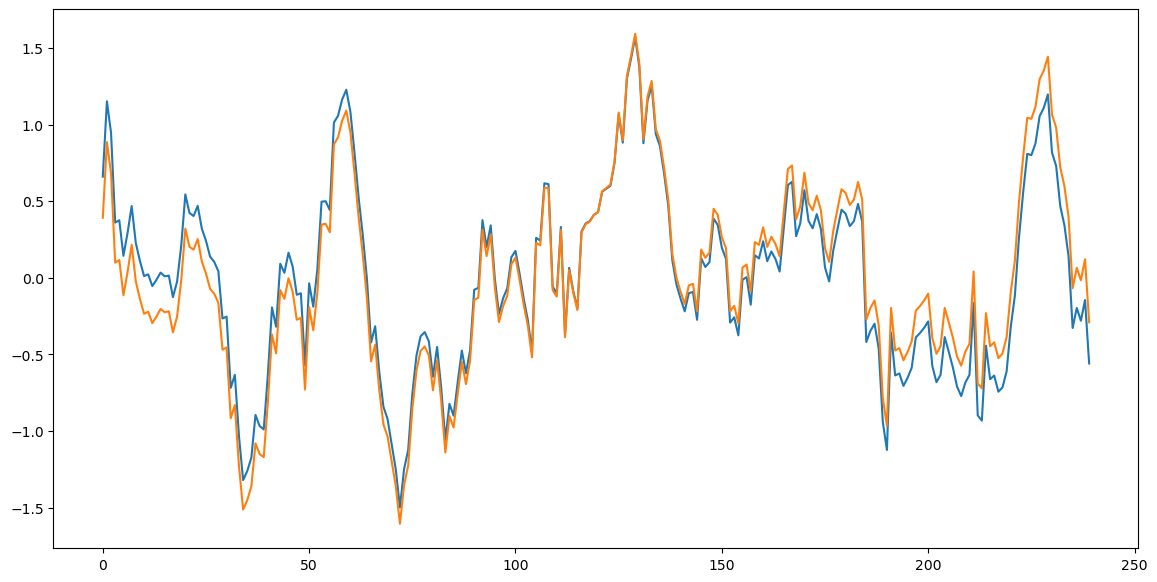

In [28]:
ix = 229
iy = 90

ceemdan = make_ceemdan()  # Create fresh CEEMDAN instance (safe in parallel)
signal = sst_detr.isel(lon=ix, lat=iy).values
signal2 = sst_anom.isel(lon=ix, lat=iy).values

plt.figure(figsize=(14,7))
plt.plot(signal)
plt.plot(signal2)


Band 1 central period of 1.0 years and standard deviation ranging from -0.0 to 0.0
Band 2 central period of 6.666666666666667 years and standard deviation ranging from -1.1764705882352942 to 0.8695652173913044
Band 3 central period of 100.0 years and standard deviation ranging from -7.142857142857143 to 6.25
Band 4 central period of -0.0 years and standard deviation ranging from -0.0 to -0.0


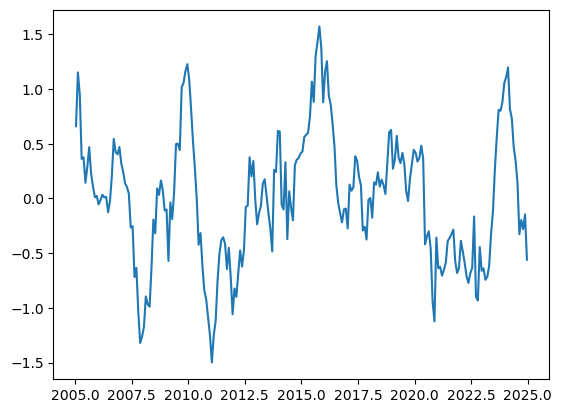

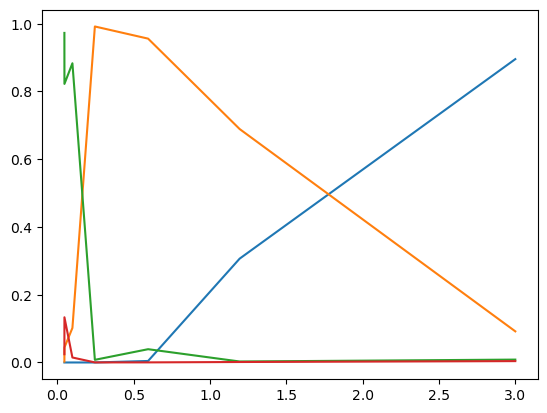

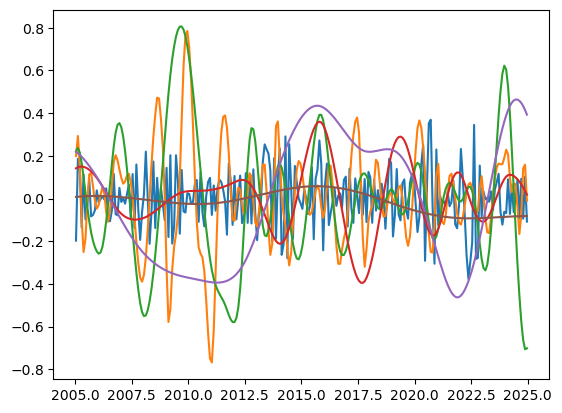

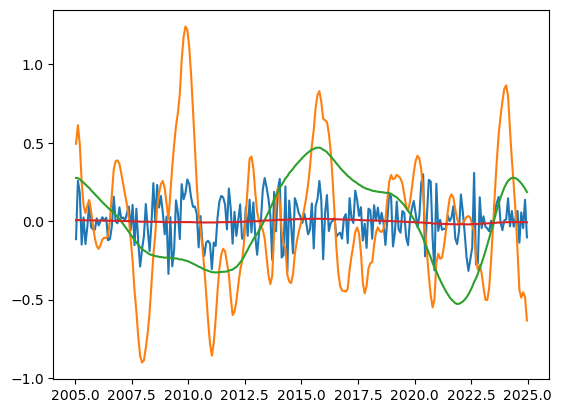

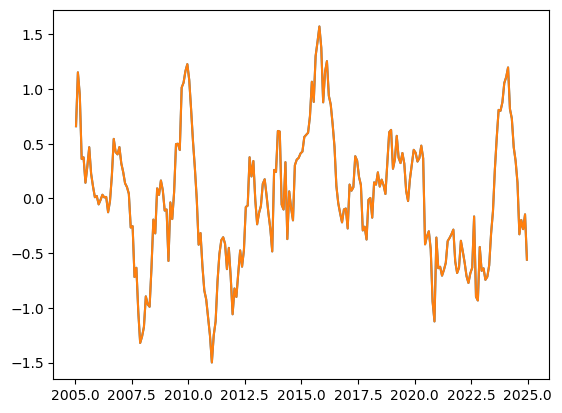

In [29]:
# Predefined cut-offs for frequency bands
bands = [
    (1.0, np.inf),       # Subannual
    (0.15, 1.0),         # Interannual
    (0.01, 0.15),        # Decadal
    (-np.inf, 0.01)       # Centennial or more
]

print(f"Band 1 central period of {1.0/bands[0][0]} years and standard deviation ranging from {1.0/(bands[0][0] - bands[0][1])} to {1.0/(bands[0][0] + bands[0][1])}")
print(f"Band 2 central period of {1.0/bands[1][0]} years and standard deviation ranging from {1.0/(bands[1][0] - bands[1][1])} to {1.0/(bands[1][0] + bands[1][1])}")
print(f"Band 3 central period of {1.0/bands[2][0]} years and standard deviation ranging from {1.0/(bands[2][0] - bands[2][1])} to {1.0/(bands[2][0] + bands[2][1])}")
print(f"Band 4 central period of {1.0/bands[3][0]} years and standard deviation ranging from {1.0/(bands[3][0] - bands[3][1])} to {1.0/(bands[3][0] + bands[3][1])}")

imfs = ceemdan(signal)
freqs = find_imf_freq_Hilbert(imfs, years)
weights = find_weights_from_freqs(imfs, bands)
result = set_bands(imfs, weights)

plt.figure()
plt.plot(years, signal)
plt.figure()
plt.plot(freqs, weights[0,:])
plt.plot(freqs, weights[1,:])
plt.plot(freqs, weights[2,:])
plt.plot(freqs, weights[3,:])
plt.figure()
plt.plot(years, imfs[0,:])
plt.plot(years, imfs[1,:])
plt.plot(years, imfs[2,:])
plt.plot(years, imfs[3,:])
plt.plot(years, imfs[4,:])
plt.plot(years, imfs[5,:])
plt.figure()
plt.plot(years, result[0,:])
plt.plot(years, result[1,:])
plt.plot(years, result[2,:])
plt.plot(years, result[3,:])
plt.figure()
plt.plot(years, signal)
plt.plot(years, np.sum(result,axis=0))

Text(0.05, 0.95, 'f')

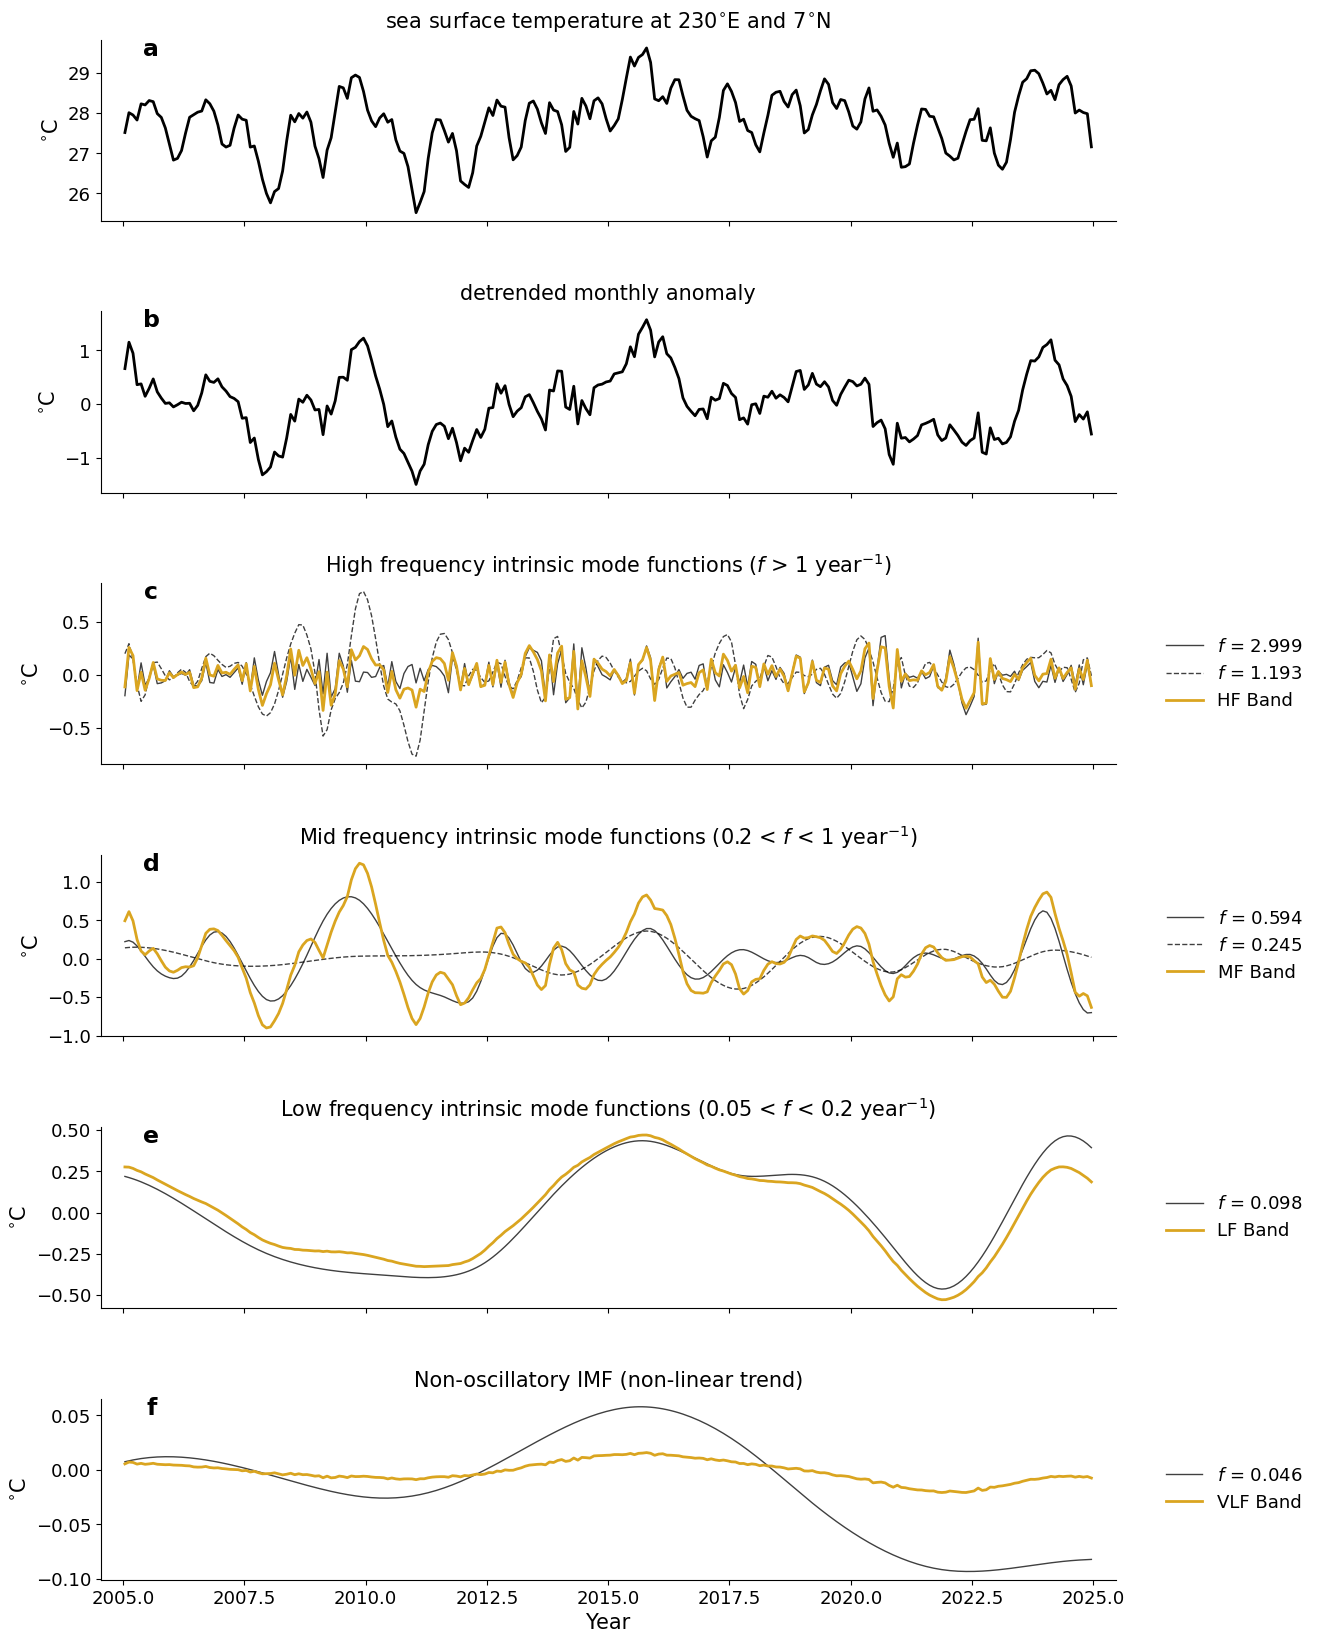

In [34]:
fslab = 15
fstic = 13
cols = ['k', 'k', 'goldenrod']
lsty = ['-', '--', '-']
lwid = [1.0, 1.0, 2.0]
alf = [0.75, 0.75, 1.0]


fig = plt.figure(figsize=(14,20))
gs = GridSpec(6,1)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])
ax5 = plt.subplot(gs[4])
ax6 = plt.subplot(gs[5])

ax1.tick_params(labelbottom=False, labelsize=fstic)
ax2.tick_params(labelbottom=False, labelsize=fstic)
ax3.tick_params(labelbottom=False, labelsize=fstic)
ax4.tick_params(labelbottom=False, labelsize=fstic)
ax5.tick_params(labelbottom=False, labelsize=fstic)
ax6.tick_params(labelsize=fstic)

ax1.spines[['top','right']].set_visible(False)
ax2.spines[['top','right']].set_visible(False)
ax3.spines[['top','right']].set_visible(False)
ax4.spines[['top','right']].set_visible(False)
ax5.spines[['top','right']].set_visible(False)
ax6.spines[['top','right']].set_visible(False)

freqs_h = find_imf_freq_Hilbert(imfs, years)

ax1.plot(years, sst.isel(lon=ix, lat=iy).values - 273.15, color=cols[0], alpha=alf[2], linestyle=lsty[2], linewidth=lwid[2])
ax2.plot(years, signal, color=cols[0], alpha=alf[2], linestyle=lsty[2], linewidth=lwid[2])
ax3.plot(years, imfs[0,:], label="$f$ = %.3f"%(freqs_h[0]), color=cols[0], alpha=alf[0], linestyle=lsty[0], linewidth=lwid[0])
ax3.plot(years, imfs[1,:], label="$f$ = %.3f"%(freqs_h[1]), color=cols[1], alpha=alf[1], linestyle=lsty[1], linewidth=lwid[1])
ax3.plot(years, result[0,:], label="HF Band", color=cols[2], alpha=alf[2], linestyle=lsty[2], linewidth=lwid[2])
ax4.plot(years, imfs[2,:], label="$f$ = %.3f"%(freqs_h[2]), color=cols[0], alpha=alf[0], linestyle=lsty[0], linewidth=lwid[0])
ax4.plot(years, imfs[3,:], label="$f$ = %.3f"%(freqs_h[3]), color=cols[1], alpha=alf[1], linestyle=lsty[1], linewidth=lwid[1])
ax4.plot(years, result[1,:], label="MF Band", color=cols[2], alpha=alf[2], linestyle=lsty[2], linewidth=lwid[2])
ax5.plot(years, imfs[4,:], label="$f$ = %.3f"%(freqs_h[4]), color=cols[0], alpha=alf[0], linestyle=lsty[0], linewidth=lwid[0])
ax5.plot(years, result[2,:], label="LF Band", color=cols[2], alpha=alf[2], linestyle=lsty[2], linewidth=lwid[2])
ax6.plot(years, imfs[5,:], label="$f$ = %.3f"%(freqs_h[5]), color=cols[0], alpha=alf[0], linestyle=lsty[0], linewidth=lwid[0])
ax6.plot(years, result[3,:], label="VLF Band", color=cols[2], alpha=alf[2], linestyle=lsty[2], linewidth=lwid[2])

ax3.legend(frameon=False, ncols=1, fontsize=fstic, bbox_to_anchor=(1.2,0.5), loc='center right')
ax4.legend(frameon=False, ncols=1, fontsize=fstic, bbox_to_anchor=(1.2,0.5), loc='center right')
ax5.legend(frameon=False, ncols=1, fontsize=fstic, bbox_to_anchor=(1.2,0.5), loc='center right')
ax6.legend(frameon=False, ncols=1, fontsize=fstic, bbox_to_anchor=(1.2,0.5), loc='center right')

ax6.set_xlabel("Year", fontsize=fslab)

xx = 0.5; yy = 1.1
plt.text(xx,yy, "sea surface temperature at %i$^{\circ}$E and %i$^{\circ}$N"%(lons[ix],lats[iy]), va='center', ha='center', fontsize=fslab, transform=ax1.transAxes)
plt.text(xx,yy, "detrended monthly anomaly", va='center', ha='center', fontsize=fslab, transform=ax2.transAxes)
plt.text(xx,yy, "High frequency intrinsic mode functions ($f$ > 1 year$^{-1}$)", va='center', ha='center', fontsize=fslab, transform=ax3.transAxes)
plt.text(xx,yy, "Mid frequency intrinsic mode functions (0.2 < $f$ < 1 year$^{-1}$)", va='center', ha='center', fontsize=fslab, transform=ax4.transAxes)
plt.text(xx,yy, "Low frequency intrinsic mode functions (0.05 < $f$ < 0.2 year$^{-1}$)", va='center', ha='center', fontsize=fslab, transform=ax5.transAxes)
plt.text(xx,yy, "Non-oscillatory IMF (non-linear trend)", va='center', ha='center', fontsize=fslab, transform=ax6.transAxes)

ax1.set_ylabel("$^{\circ}$C", fontsize=fslab)
ax2.set_ylabel("$^{\circ}$C", fontsize=fslab)
ax3.set_ylabel("$^{\circ}$C", fontsize=fslab)
ax4.set_ylabel("$^{\circ}$C", fontsize=fslab)
ax5.set_ylabel("$^{\circ}$C", fontsize=fslab)
ax6.set_ylabel("$^{\circ}$C", fontsize=fslab)

plt.subplots_adjust(hspace=0.5, right=0.85)

ax1.set_xlim(years[0]-0.5, years[-1]+0.5)
ax2.set_xlim(years[0]-0.5, years[-1]+0.5)
ax3.set_xlim(years[0]-0.5, years[-1]+0.5)
ax4.set_xlim(years[0]-0.5, years[-1]+0.5)
ax5.set_xlim(years[0]-0.5, years[-1]+0.5)
ax6.set_xlim(years[0]-0.5, years[-1]+0.5)

xx = 0.05; yy = 0.95
plt.text(xx,yy, "a", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax1.transAxes)
plt.text(xx,yy, "b", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax2.transAxes)
plt.text(xx,yy, "c", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax3.transAxes)
plt.text(xx,yy, "d", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax4.transAxes)
plt.text(xx,yy, "e", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax5.transAxes)
plt.text(xx,yy, "f", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax6.transAxes)



In [35]:
os.getcwd()
fig.savefig(wrkdir + "/figures/CEEMDAN_example.png", dpi=300)
fig.savefig(wrkdir + "/figures/CEEMDAN_example.pdf", dpi=300)


## run for SST

In [ ]:
%%time

# Coordinate pairs
ntime = len(times)
nlat = len(lats)
nlon = len(lons)
coords = [(ix, iy) for ix in range(nlon) for iy in range(nlat)]

# Predefined cut-offs for frequency bands
bands = [
    (1.0, np.inf),       # Subannual
    (0.15, 1.0),         # Interannual
    (0.01, 0.15),        # Decadal
    (-np.inf, 0.01)       # Centennial or more
]

# Run in parallel
results = Parallel(n_jobs=56, backend='loky', verbose=10)(
    delayed(process_cell)(ix, iy) for (ix, iy) in coords
)


[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=56)]: Done   1 tasks      | elapsed:   21.5s
[Parallel(n_jobs=56)]: Done  16 tasks      | elapsed:   24.6s
[Parallel(n_jobs=56)]: Done  33 tasks      | elapsed:   27.7s
[Parallel(n_jobs=56)]: Done  50 tasks      | elapsed:   27.8s
[Parallel(n_jobs=56)]: Done  69 tasks      | elapsed:   28.4s
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:   29.9s
[Parallel(n_jobs=56)]: Done 109 tasks      | elapsed:   31.9s
[Parallel(n_jobs=56)]: Done 130 tasks      | elapsed:   33.3s
[Parallel(n_jobs=56)]: Done 153 tasks      | elapsed:   36.6s
[Parallel(n_jobs=56)]: Done 176 tasks      | elapsed:   38.9s
[Parallel(n_jobs=56)]: Done 201 tasks      | elapsed:   41.8s
[Parallel(n_jobs=56)]: Done 226 tasks      | elapsed:   42.5s
[Parallel(n_jobs=56)]: Done 253 tasks      | elapsed:   43.4s
[Parallel(n_jobs=56)]: Done 280 tasks      | elapsed:   46.7s
[Parallel(n_jobs=56)]: Done 309 tasks      | elapsed:  

In [41]:
%%time

sst_imfs = np.zeros((4,len(times),len(lats),len(lons)))

# Assemble results
for ix, iy, grouped in results:
    if grouped is not None:
        sst_imfs[:, :, iy, ix] = grouped



CPU times: user 1.03 s, sys: 390 ms, total: 1.42 s
Wall time: 1.42 s


In [44]:
%%time

# Create xarray Datasets
imfs_sst_ds = xr.Dataset(
    {
        "sst_imfs": (["IMF", "time", "lat", "lon"], sst_imfs),
        "sst_anom": (["time", "lat", "lon"], sst_anom.values),
        "sst_detr": (["time", "lat", "lon"], sst_detr.transpose("time", "lat", "lon").values),
        "sst_trend": (["lat", "lon"], sst_trend.values),
    },
    coords={
        "IMF": np.arange(1,5,1),
        "time": dates,
        "lat": lats,
        "lon": lons,
    },
)
os.chdir(wrkdir + "/data/")
os.remove("imfs_sst_CEEMDAN.nc")
imfs_sst_ds.to_netcdf("imfs_sst_CEEMDAN.nc")


CPU times: user 123 ms, sys: 1.14 s, total: 1.27 s
Wall time: 1.6 s
